# Segformer (Nvidia)
## Testing Segformer-b1

In [ ]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

helper_path = os.path.abspath(os.path.join('../helper'))
if helper_path not in sys.path:
    sys.path.append(helper_path)

In [1]:
from helper.models.config import *
from helper.models.nvidia_ade20k import *
from helper.data.dataobj import DrainageDataset
from torch.utils.data import DataLoader
from helper.data.dataobj import DrainageDataset
from sklearn.model_selection import train_test_split
from helper.utilities import *
from helper.callbacks.logs import save_history_callback, save_resulting_callback
from helper.callbacks.visualize import *
import numpy as np

## Loading model

In [2]:
device = 'cuda'
segformer_model = NvidiaSegformer(device=device)
segformer_model.load('../helper/models/saved/NvidiaSegformer-7.pt')

Initialized NvidiaSegformer


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [3]:
config_nvidia = Config(
    model=segformer_model,
    num_epochs=200,
    opt='Adam',
    lr=1e-4
)
print(config_nvidia.get_params())

{'num_epochs': 200, 'batch_size': 64, 'opt': 'Adam', 'crit': 'CrossEntropy', 'learning_rate': 0.0001}


## Dataset

In [4]:
images = np.load('../helper/data/datasets/new_images.npy').astype(np.uint8)
masks = np.load('../helper/data/datasets/new_masks.npy')

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print('Getting test dataset')
bins = [get_bin(mask) for mask in masks]

train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=test_ratio, stratify=bins, random_state=42)

test_dataset = DrainageDataset(test_images, test_masks, device=device, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Getting test dataset


## Testing model

In [5]:
details = segformer_model.test_epoch(test_dataloader, config_nvidia.criterion, device='cuda', detailed=True)
save_resulting_callback(segformer_model, metrics=details, hyperparams=config_nvidia.get_params())
print(f'Saved details of testing {segformer_model.get_name()}')

Saved details of testing NvidiaSegformer


## Visualizing

### Getting metrics vizualization

g:\NIER\code\helper\callbacks\visualize.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette='Paired')


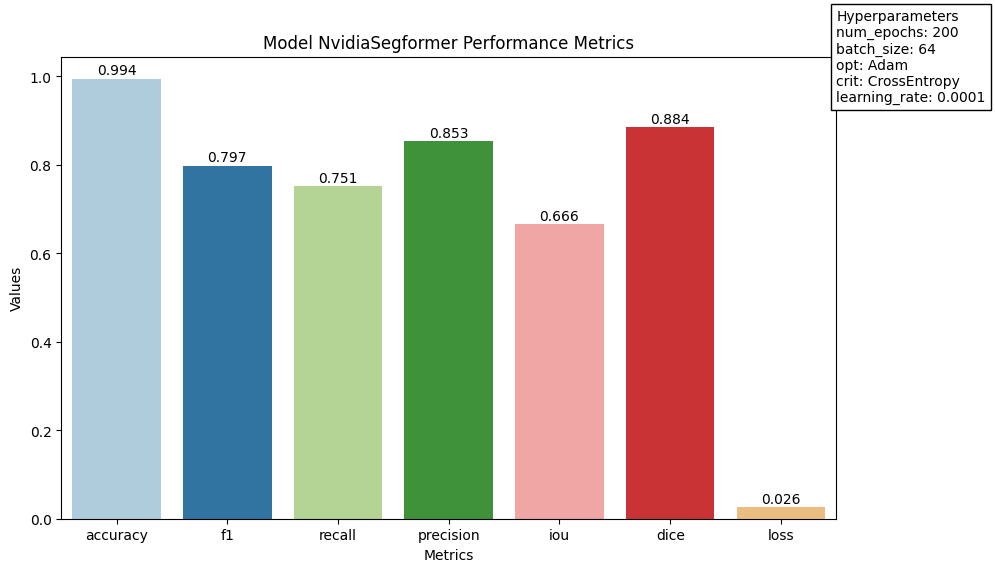

In [6]:
draw_resulting_log('NvidiaSegformer-7.json')

### Model's predicts examples

mask: torch.Size([256, 256])
inter: torch.Size([256, 256])


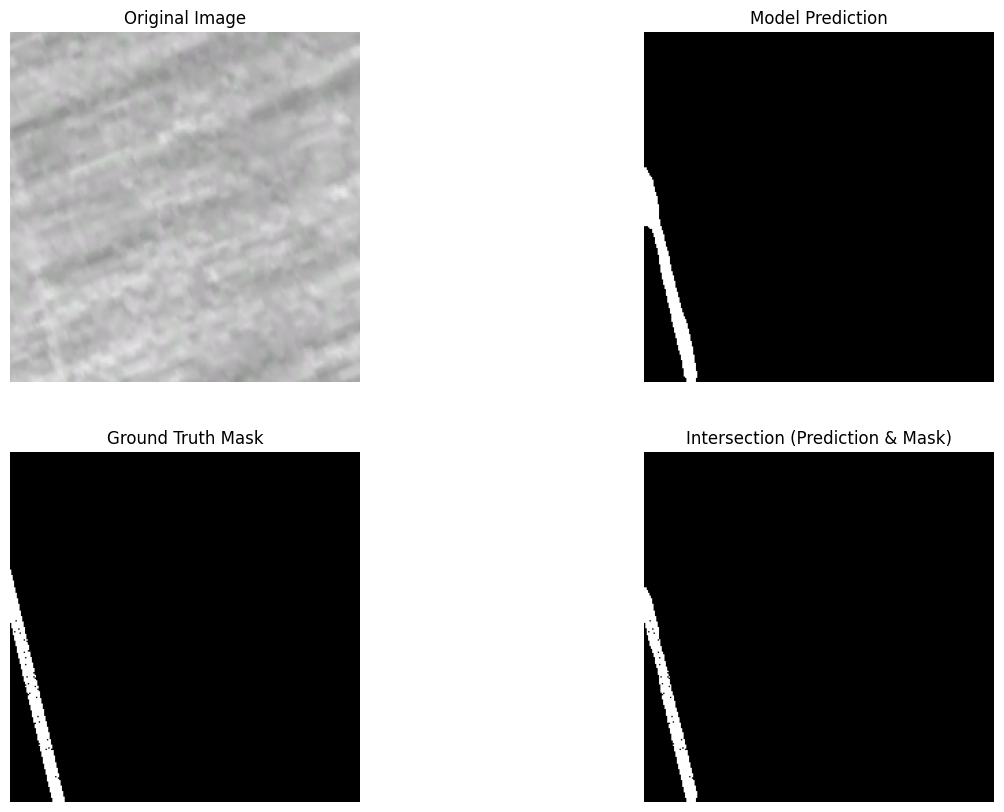

In [7]:
image, mask = test_dataset[11] # 0 1 10 11 12
segformer_model.predict(image, mask, device)